In [2]:
!pip install pandas

/bin/bash: /home/seuyon0101/anaconda3/envs/saturi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

ModuleNotFoundError: No module named 'pandas'

# Step 1. 데이터 불러오기
   

In [2]:
data_dir = os.getenv("HOME") + '/aiffel/DATA'

In [3]:
data_test_path = data_dir+"/data_test_spm_4000_0317.pkl"
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test['weight'] = full_data_test['tok_cat'].apply(lambda x : 14 - x)
full_data_test = full_data_test.loc[full_data_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림
test_idx = full_data_test.index

In [4]:
# # train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
data_train_path = data_dir+"/data_train_custom_msp_4000_0321.pkl"
data_test_path = data_dir+"/data_test_custom_msp_4000_0321.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test = full_data_test.iloc[test_idx].copy()

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340262 entries, 0 to 1340261
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   reg       1340262 non-null  object
 1   topic     1340262 non-null  object
 2   eng       1340262 non-null  object
 3   dial      1340262 non-null  object
 4   tok_len   1340262 non-null  int64 
 5   tok_cat   1340262 non-null  int64 
 6   toks_en   1340262 non-null  object
 7   toks_dec  1340262 non-null  object
dtypes: int64(2), object(6)
memory usage: 81.8+ MB


In [6]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1362 to 893
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       250 non-null    object
 1   topic     250 non-null    object
 2   eng       250 non-null    object
 3   dial      250 non-null    object
 4   tok_len   250 non-null    int64 
 5   tok_cat   250 non-null    int64 
 6   toks_en   250 non-null    object
 7   toks_dec  250 non-null    object
dtypes: int64(2), object(6)
memory usage: 17.6+ KB


In [7]:
regs = full_data.reg.unique()

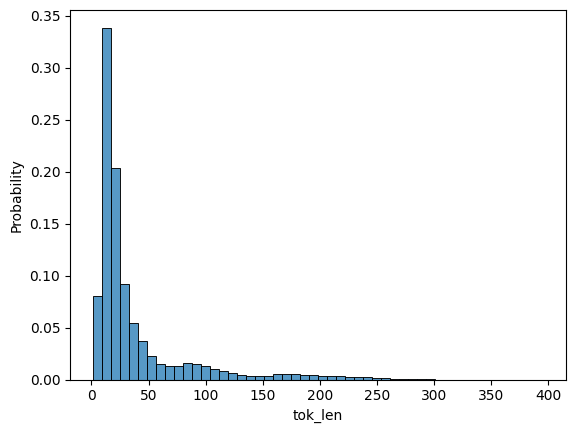

In [8]:
import seaborn as sns
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [9]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    43.703436
gs    40.892672
jd    41.953760
jj    34.078127
kw    34.169373
Name: tok_len, dtype: float64

In [10]:
# full_data['len_cat'] = pd.qcut(full_data['tok_len'], [0,0.7,0.8,0.85,0.9,0.92,0.94,0.96,0.98,0.985,0.986,0.994,0.999,1],labels =[1,2,3,4,5,6,7,8,9,10,11,12,13])

In [11]:
full_data.loc[full_data['tok_cat']==5,'tok_len'].agg([min,max])

min     97
max    109
Name: tok_len, dtype: int64

In [12]:
data_path = os.getenv('HOME') + '/aiffel/saturi/notebook/Preprocessing/'
SRC_VOCAB_SIZE = 4009
TGT_VOCAB_SIZE = 4009

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load('spm_enc_v.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+'/spm_dec_custom_mecab_4009.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델불러오기

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: seuyon0101. Use `wandb login --relogin` to force relogin


True

In [14]:
#wandb 설정
run  = wandb.init(project = 'model_exp_custom_msp4009_0321',
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer',
                     'n_layers':6,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len': 512,
                     'dropout':0.2,
                     'shared':True,
                     'warmups' : 4000,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                 })
config = wandb.config

wandb: Currently logged in as: seuyon0101 (saturi). Use `wandb login --relogin` to force relogin


In [15]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [16]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

2023-03-21 13:51:22.176374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 13:51:22.176666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 13:51:22.176728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-21 13:51:22.176785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-21 13:51:22.187325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [18]:
learningrate = LearningRateScheduler(512)

In [19]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [20]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [21]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [22]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [23]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0
        total_loss_val = 0
        bleu_train = 0
        bleu_valid = 0
        

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                         dec_train[idx:idx+batch_size],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss
            
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
            
        #validation
        for test_idx in range(0,enc_test.shape[0], batch_size) :
            val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + batch_size],
                                      dec_test[test_idx : test_idx + batch_size],
                                      transformer)
            total_loss_val += val_loss

        wandb.log({
                   "train_loss": total_loss.numpy() / (len(t) + 1),
                   "valid_loss" : total_loss_val.numpy() / (enc_test.shape[0]//batch_size),
                   })

        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +'tf_custom_msp4000_ckpt_0321v1',max_to_keep=3)

## 학습

In [26]:
#bucketing and training

batch_size = 32
buckets = iter(full_data['tok_cat'].unique().tolist())

for bucket in buckets :

    src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
    tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
    src_valid_corpus = full_data_test['toks_en'].values
    tgt_valid_corpus = full_data_test['toks_dec'].values
    max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()
    
    if max_len > 380 :
        batch_size = 8
        
    if max_len > 512 : 
        max_len = 512
        
    enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
    dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
    enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
    dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)

    print(enc_train.shape)
    print(dec_train.shape)
    print(enc_test.shape)
    print(dec_test.shape)
    
    
    #Train
    train_and_checkpoint(transformer, manager, config.epochs)

(945858, 31)
(945858, 31)
(250, 31)
(250, 31)
Restored from /home/seuyon0101/aiffel/MODEL/tf_custom_msp4000_ckpt_0321v1/ckpt-26


Epoch  1:   0%|               | 3/29559 [00:15<43:15:20,  5.27s/it, Loss 2.5990]


KeyboardInterrupt: 

# Step 3. 평가

In [47]:
from evaluation import translate
from time import perf_counter

In [48]:
examples = ["<jj> what are you doing?",'<cc> what are you doing?','<gs> what are you doing?','<jd> what are you doing?','<kw> what are you doing?']

In [49]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> what are you doing?
Predicted translation: 거 거 거 거 거 거 거
Input: <cc> what are you doing?
Predicted translation: 냐 뭐~ 냐 뭐~ 뭐
Input: <gs> what are you doing?
Predicted translation: 니느 뭐~ 니느 뭐
Input: <jd> what are you doing?
Predicted translation: 모 모빠 모빠 모빠
Input: <kw> what are you doing?
Predicted translation: 지굼 뭐러 하시는 말씸
5.327321469998424


In [50]:
full_data_test.sort_values(by='tok_cat', inplace=True)

In [51]:
test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

In [52]:
from datasets import load_metric
bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []
for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

100%|█████████████████████████████████████████| 250/250 [19:44<00:00,  4.74s/it]


In [53]:
sum(bleu_valid_score)/len(test_text)

7.2810210688685775

In [54]:
wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

In [55]:
full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

In [56]:
full_data_test.loc[:,['tok_cat','topic','reg','dial','pred','bleu']].sort_values('bleu')

,tok_cat,topic,reg,dial,pred,bleu
711,1,방송/연예,cc,마저 만나믄 내도 아마 구 말부통 나올 꺼 같어.,아마도 쫌 약깐 쫌 윤아래가 아마도 아마도 쫌 핬을,0.000000
876,1,게임,cc,에서 최근이 허는 께임 구 쩡도 있는디 혹시 최근이 따른 께임 하신 껀 드 없으슈 ...,거서 인자 쪼끼 쪼끼 쪼끼 쪼끼가 있으 가주구 최근에는 또 뭐~ 니가 뭐,0.000000
972,1,SNS,gs,니 드가서 봔 적 있나?,니느 뭐~ 니느 뭐~,0.000000
1097,1,건강,gs,어뜬 분은 또 힘든데 랑 하느노 이르케 하디마,그~ 뭐~ 그~ 뭐~ 그~ 뭐~ 뭐~,0.000000
1026,1,가족,gs,그서 걍,-그- 그~ -그- 그,0.000000
...,...,...,...,...,...,...
530,1,가족,jj,하르방 얘기를 골믄 인제 거 하르방이,인제 거 하르방신디 골아라게 말,27.821195
1163,1,경제,gs,사람이서 어뜨케 보믄 쫌 꼼꼼하거나,어뜨케 보믄 사람이서 쫌 꼼꼼하꼬 고런,32.466792
482,1,자동차/오토바이,jj,거 거 주술 생각이랑마랑,거 거 거 거 거,33.980885
1206,1,드라마,kw,즌화 자주 하라우.,자주 전화하셨사. 지,37.991784


In [121]:
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + '/test_results_custom_msp4000.csv')

In [57]:
wandb.finish()

Widget Javascript not detected.  It may not be installed or enabled properly.


bleu,▁
train_loss,▂▃▂█▁▃▂▁▄▃▂▃▆
valid_loss,█▅▃▄▂▃▃▂▄▄▄▄▁
bleu,7.28102
train_loss,2.84211
valid_loss,2.86343
